# K-nearest neighbors (KNN)
___

The K-nearest neighbors (KNN) algorithm is a supervised machine learning algorithm used for classification and regression tasks. It works by finding the K closest data points to a query point and making predictions based on their labels or values.

#### Mathematical Foundation

The KNN algorithm relies on distance metrics to determine similarity between data points. The most common distance metric used is Euclidean distance, calculated as:

$$d = \sqrt{\sum_{i=1}^n (x_i - y_i)^2}$$

where x and y are two data points with n features.

#### Purpose and Functionality

KNN classifies new data points based on the majority class of their K nearest neighbors. The value of K is a hyperparameter that determines how many neighbors to consider. For classification tasks, KNN uses majority voting, while for regression, it uses the average of the K neighbors' values.

#### Benefits

1. Simple implementation and intuitive concept
2. No training phase required, making it time-efficient for quick modeling
3. Easily adapts to multi-class problems
4. Non-parametric, making no assumptions about data distribution

#### Limitations

1. Computationally expensive for large datasets, especially during prediction
2. Sensitive to the curse of dimensionality, performing poorly with high-dimensional data
3. Requires careful selection of K and distance metric
4. Prone to overfitting with small K values and underfitting with large K values
5. Lack of interpretability in predictions

KNN's performance depends heavily on the choice of K and the distance metric used. Cross-validation can help determine the optimal K value for a given dataset. Despite its limitations, KNN remains a powerful and versatile algorithm for both classification and regression tasks due to its simplicity and effectiveness.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import operator

In [14]:
penguins = sns.load_dataset('penguins').dropna()

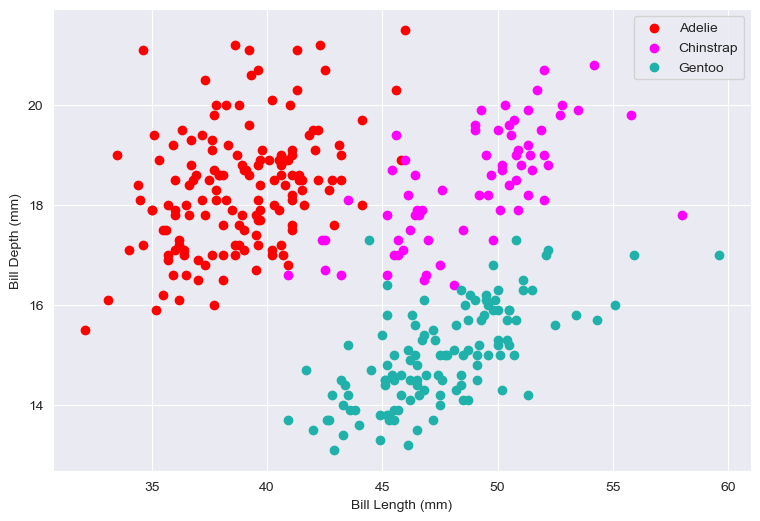

In [15]:
# Assign colors to each species for visualization
colors = dict(zip(penguins['species'].unique(), ["red", "magenta", "lightseagreen"]))

fig, ax = plt.subplots(figsize=(9, 6))
for s, c in colors.items():
    plot_i = penguins[penguins.species == s]  # Plot each species with its corresponding color
    ax.scatter(plot_i.bill_length_mm, plot_i.bill_depth_mm, color=c, label=s)

ax.set_xlabel('Bill Length (mm)')
ax.set_ylabel('Bill Depth (mm)')
ax.legend()
plt.show()

In [16]:
X = penguins[['bill_length_mm', 'bill_depth_mm']].to_numpy()  # Get feature and label arrays
y = penguins['species'].to_numpy()

# Split feature and label data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [17]:
def d(a, b):
    """
    The Euclidian distance between two vectors.
    :param a: Vector 1
    :param b: Vector 2
    :return: Euclidean Distance
    """
    return np.sqrt((a-b) @ (a-b))

from em_el.utils import euclidean

In [18]:
def k_nearest(target, X, y, K):
    """
    Finds the K nearest neighbors of a given point in a dataset.
    
    :param X: A numpy array of shape (n_samples, n_features) containing the feature vectors of the training data.
    :param y: A numpy array of shape (n_samples,) containing the corresponding labels for the training data.
    :param x_n: A numpy array of shape (n_features,) representing the query point.
    :param K: The number of nearest neighbors to return.
    
    :return: A list of tuples, where each tuple contains:
            - The distance to the query point.
            - The feature vector of the neighbor.
            - The label of the neighbor.
        The list is sorted in ascending order of distance.
    """
    distances = [(d(x, target), x, y) for x, y in zip(X, y)]
    distances = sorted(distances, key=operator.itemgetter(0))  # Sort the list by the distances
    
    return distances[:K]


In [19]:
def KNN(target, X, y, K, regression=False):
    """
    Implements the K-Nearest Neighbors (KNN) algorithm for classification or regression.
    
    For classification:
        - Finds the K nearest neighbors to the `target` point.
        - Returns the most frequent label among the K nearest neighbors.

    For regression:
        - Finds the K nearest neighbors to the `target` point.
        - Returns the average target value of the K nearest neighbors.
    
    :param X: A numpy array containing the feature vectors of the training data.
    :param y: A numpy array containing the labels or target values of the training data.
    :param target: A numpy array representing the feature vector of the point to classify or regress.
    :param K: The number of nearest neighbors to consider (default is 3).
    :param regression: A boolean flag indicating whether to perform regression (True) or classification (False).

    :return: predicted label or target value for the input `target` point.
    """
    neighbors = k_nearest(target, X, y, K)
    if regression:
        return np.mean([x[2] for x in neighbors])
    else:
        labels = [n[2] for n in neighbors]
        return max(labels, key=labels.count)

In [20]:
KNN(X_train[1], X_train, y_train, 4)

'Adelie'

In [25]:
def classification_error(train_X, train_y, test_X, test_y, K):
    """
    Calculates the classification error rate of a K-Nearest Neighbors (KNN) classifier.

    :param test_X: A numpy array containing the feature vectors of the test data.
    :param test_y: A numpy array containing the true labels of the test data.
    :param train_X: A numpy array containing the feature vectors of the training data.
    :param train_y: A numpy array containing the true labels of the training data.
    :param K: The number of nearest neighbors to consider.

    :return: The classification error rate of the K-Nearest Neighbors (KNN) classifier, which is the proportion of misclassified test points.
    """
    error = 0
    for x_i, y_i in zip(test_X, test_y):
        error += y_i != KNN(x_i, train_X, train_y, K)
    return error / len(test_X)

In [26]:
classification_error(X_train, y_train, X_test, y_test, 4)

0.07

In [27]:
possible_k = [k for k in range(3, 26, 2)]  # Test different values of K
errors = [classification_error(X_test, y_test, X_train, y_train, k) for k in possible_k]

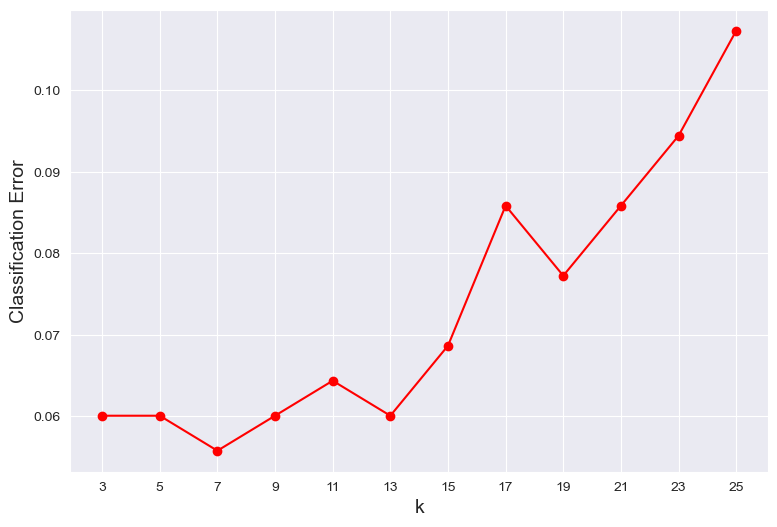

In [28]:
# Plot the different error values vs k values
plt.figure(figsize = (9, 6))
plt.plot(possible_k, errors, color = 'red', marker = "o")
plt.xlabel('k', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)
plt.xticks(possible_k)
plt.show()